# Titanic Model V3 - XGBoost Tuning
**目的:** 探索 XGBoost 調參邊界，尋找最穩定泛化參數組合  
**依據:** Model V3 主流程，從固定 feature set 出發進行GridSearchCV比較  

## Section 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Section 2: Load Data and Apply Feature Engineering & Imputation

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# Feature Engineering
def extract_title(df):
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    df['Title_Grouped'] = df['Title'].replace({
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare',
        'Col': 'Rare', 'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare',
        'Rev': 'Rare', 'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
    })
    return df

def add_family_features(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    return df

def engineer_features(df):
    df = extract_title(df)
    df = add_family_features(df)
    return df

train = engineer_features(train)
test = engineer_features(test)

# Imputation
title_age_medians = train.groupby('Title_Grouped')['Age'].median()

def impute_age(df):
    df['Age'] = df.apply(
        lambda row: title_age_medians[row['Title_Grouped']] if pd.isnull(row['Age']) else row['Age'],
        axis=1
    )
    return df

train = impute_age(train)
test = impute_age(test)

train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

# Feature Selection
features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
    'Title_Grouped', 'FamilySize', 'IsAlone', 'FarePerPerson'
]

X = train[features]
y = train['Survived']

## Section 3: Preprocessing Pipeline

In [3]:
numeric_features = ['Age', 'Fare', 'FamilySize', 'FarePerPerson']
categorical_features = ['Pclass', 'Sex', 'Title_Grouped', 'IsAlone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## Section 4: XGBoost + GridSearchCV

In [9]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
}

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb)
])

grid_search = GridSearchCV(
    clf, param_grid, cv=5,
    scoring='accuracy', verbose=2, n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'FamilySize',
                                                                          'FarePerPerson']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Title_Grouped',
                                                                          'IsAlone...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

## Section 5: Evaluation and Visualization GridSearch

                                               params  mean_test_score  \
13  {'xgb__learning_rate': 0.2, 'xgb__max_depth': ...         0.836125   
1   {'xgb__learning_rate': 0.01, 'xgb__max_depth':...         0.833890   
6   {'xgb__learning_rate': 0.1, 'xgb__max_depth': ...         0.833890   
8   {'xgb__learning_rate': 0.1, 'xgb__max_depth': ...         0.833890   
7   {'xgb__learning_rate': 0.1, 'xgb__max_depth': ...         0.832773   

    std_test_score  
13        0.020943  
1         0.021527  
6         0.016555  
8         0.019037  
7         0.018591  


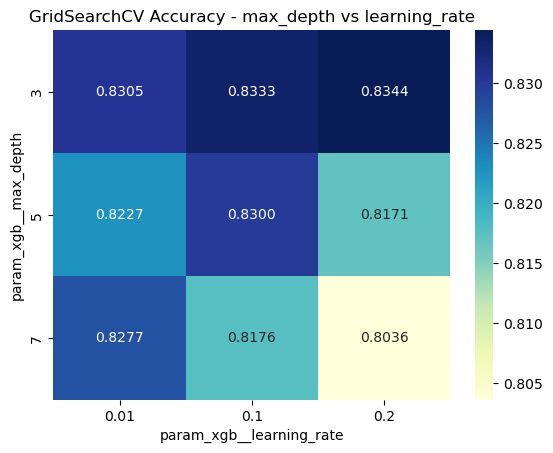

Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best CV Accuracy: 0.8361245370660976


In [10]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# 顯示 Top 5
print(results_df[["params", "mean_test_score", "std_test_score"]].head())

# Heatmap (只支援2D參數視覺化)
pivot = results_df.pivot_table(
    values='mean_test_score',
    index='param_xgb__max_depth',
    columns='param_xgb__learning_rate'
)
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("GridSearchCV Accuracy - max_depth vs learning_rate")
plt.show()

# Best Parameters
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)